In [1]:
import math
import numpy as np
import matplotlib.pyplot as plot
%matplotlib inline

In [2]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [3]:
a = Value(2.); a.label='a'
b = Value(1.2); b.label='b'
c = a / b; c.label='c'
d = c + 3; d.label='d'
f = d.exp(); f.label='f'

f

Value(data=106.34267539816554)

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

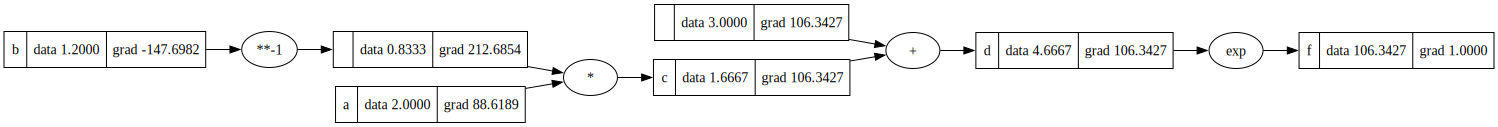

In [5]:
sorted_nodes = []
visited = set()
def topo(node):
    if node not in visited:
        visited.add(node)
        for child in node._prev:
            topo(child)
        sorted_nodes.append(node)
topo(f)
f.grad = 1
for node in reversed(sorted_nodes):
    node._backward

f.backward()

draw_dot(f)


In [6]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.grad = 1
o.backward()

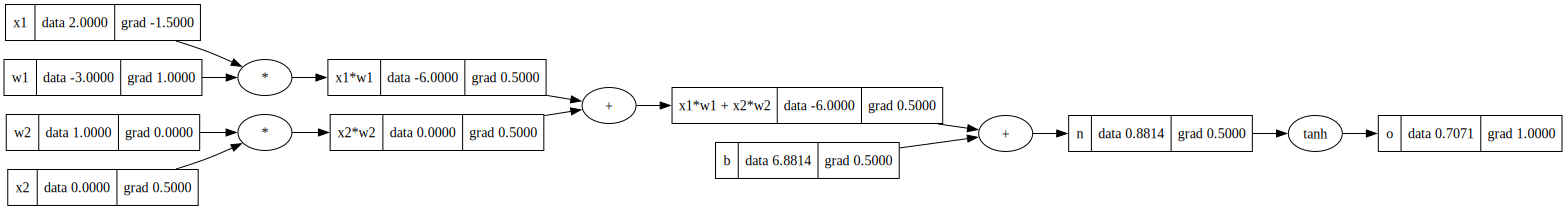

In [7]:
draw_dot(o)

In [8]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137358]).double(); b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()

print("----")

print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
----
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [20]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * c + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [22]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
v = n(x)

In [23]:

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [41]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    print(k, loss.data)

ypred

0 0.0006285678342439323
1 0.0006266750024417077
2 0.0006247934373425725
3 0.0006229230387777235
4 0.0006210637077631025
5 0.0006192153464818976
6 0.0006173778582673434
7 0.0006155511475859285
8 0.0006137351200206753
9 0.000611929682254986
10 0.0006101347420565521
11 0.0006083502082616882
12 0.0006065759907598115
13 0.0006048120004783339
14 0.0006030581493676715
15 0.0006013143503866479
16 0.0005995805174880145
17 0.0005978565656043425
18 0.0005961424106340413
19 0.0005944379694277469


[Value(data=0.9897614985105551),
 Value(data=-0.9879738032286077),
 Value(data=-0.9893258223139029),
 Value(data=0.9847998822827005)]

In [39]:
n.parameters()

[Value(data=-0.25465001302537676),
 Value(data=0.2898262639694688),
 Value(data=-1.1313841138736684),
 Value(data=-0.6273110340078512),
 Value(data=-0.1561262110998233),
 Value(data=-0.8189626037978152),
 Value(data=0.8126972286966591),
 Value(data=0.8884476693957479),
 Value(data=-0.8273143183923627),
 Value(data=0.29788581338336567),
 Value(data=0.066821706026444),
 Value(data=0.4634143457915173),
 Value(data=0.4596735600035786),
 Value(data=-0.04551955074872695),
 Value(data=1.170068384296616),
 Value(data=-0.9156015841803672),
 Value(data=-0.7625191937925039),
 Value(data=0.8293065124477198),
 Value(data=0.4033327546558594),
 Value(data=0.061364375990509125),
 Value(data=-0.44292858534010193),
 Value(data=0.12971279997247723),
 Value(data=0.11766321418264089),
 Value(data=0.3215388291090372),
 Value(data=0.6584890048260706),
 Value(data=-0.6067372663546259),
 Value(data=-0.43603090201193484),
 Value(data=0.0954523060083235),
 Value(data=0.19026527041210775),
 Value(data=0.836785329